In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dola553","key":"31d1e8b3ce554105def233c0f78ebe7c"}'}

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!kaggle datasets download -d chethuhn/water-bottle-dataset

Dataset URL: https://www.kaggle.com/datasets/chethuhn/water-bottle-dataset
License(s): CC0-1.0
 98% 63.0M/64.2M [00:01<00:00, 61.4MB/s]
100% 64.2M/64.2M [00:01<00:00, 50.5MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('water-bottle-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import os, random
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from PIL import Image
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import cm

In [7]:
import glob
full = []
label1=[]
for img in glob.glob("/content/Full  Water level/Full  Water level/*.jpeg")+ glob.glob("/content/Full  Water level/Full  Water level/*.png"):

    n= cv2.imread(img)
    n = Image.fromarray(n,'RGB')
    n_res=n.resize((80,80))
    full.append(n_res)
    label1.append(0)

half = []
label2=[]
for img in glob.glob("/content/Half water level/Half water level/*.jpeg")+glob.glob("/content/Half water level/Half water level/*.png"):
    m= cv2.imread(img)
    m = Image.fromarray(m,'RGB')
    m_res=m.resize((80,80))
    m1=m_res.rotate(15)
    half.append(m_res)
    half.append(m1)
    label2.append(1)
    label2.append(1)

over = []
label3=[]
for img in glob.glob("/content/Overflowing/Overflowing/*.jpeg")+glob.glob("/content/Overflowing/Overflowing/*.png"):
    m= cv2.imread(img)
    m = Image.fromarray(m,'RGB')
    m_res=m.resize((80,80))
    m1=m_res.rotate(15)
    m2=m_res.rotate(-15)
    over.append(m_res)
    over.append(m1)
    over.append(m2)
    label3.append(2)
    label3.append(2)
    label3.append(2)

In [8]:
len(full), len(half) ,len(over)


(308, 278, 117)

In [9]:
img=full+half+over
label=label1+label2+label3

In [10]:
img = np.array(img)
label= np.array(label)

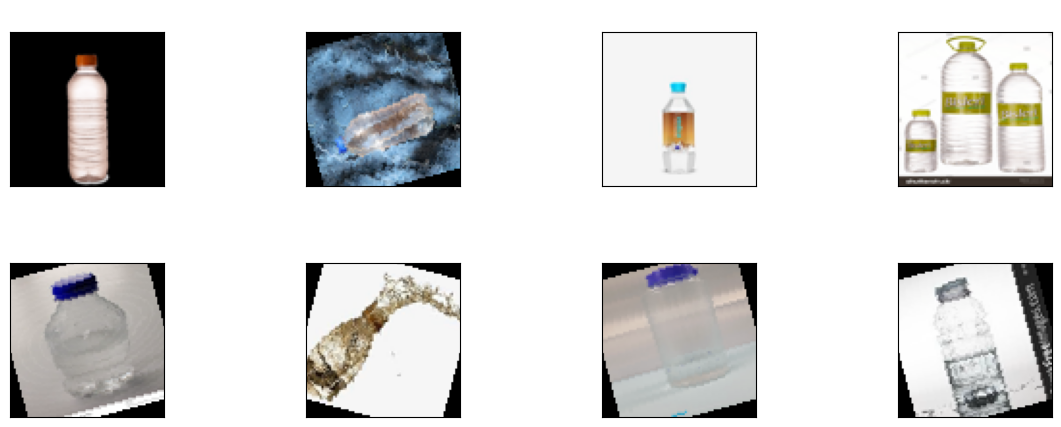

In [25]:
plt.figure(figsize=(14,5))
x, y = 4, 2
for i in range(8):
    r = np.random.randint(0 , img.shape[0] , 1)
    plt.subplot(y, x, i+1)
    plt.imshow(img[r[0]], cmap='gray')
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.title(label[r[0]],color="w")
    plt.xticks([]) , plt.yticks([])
plt.show()

In [11]:
imgs=[]
from tensorflow.keras.utils import img_to_array
for i in img:
  x = img_to_array(i)
  imgs.append(x)
imgs = np.array(imgs)/255
imgs.shape

(703, 80, 80, 3)

In [12]:
datagen = ImageDataGenerator(height_shift_range=0.3,fill_mode='nearest')
datagen.fit(imgs)
generated_imgs = []
generated_labels = []
for x_batch, y_batch in datagen.flow(imgs, label, batch_size=1):
    generated_imgs.extend(x_batch)
    generated_labels.extend(y_batch)
    if len(generated_imgs) >= imgs.shape[0]:
        break
imgs = np.concatenate((imgs, generated_imgs))
label = np.concatenate((label, generated_labels))

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                             rotation_range=10,fill_mode='nearest')
datagen.fit(imgs)
generated_imgs = []
generated_labels = []
for x_batch, y_batch in datagen.flow(imgs, label, batch_size=1):
    generated_imgs.extend(x_batch)
    generated_labels.extend(y_batch)
    if len(generated_imgs) >= imgs.shape[0]:
        break
imgs = np.concatenate((imgs, generated_imgs))
label = np.concatenate((label, generated_labels))

In [14]:
imgs.shape,label.shape

((2812, 80, 80, 3), (2812,))

In [15]:
from sklearn.model_selection import train_test_split
label_cat=to_categorical(label,3)
x_train , x_test , y_train , y_test = train_test_split(imgs, label,
                                            test_size = 0.25,
                                            random_state = 42)

In [16]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((2109, 80, 80, 3), (703, 80, 80, 3), (2109,), (703,))

In [17]:
np.unique(y_train,return_counts=True)

(array([0, 1, 2]), array([933, 816, 360]))

In [18]:
np.unique(y_test,return_counts=True)


(array([0, 1, 2]), array([299, 296, 108]))

In [19]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.7534833869239014, 1: 0.8615196078431373, 2: 1.9527777777777777}

In [20]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_train.shape,y_test.shape

((2109, 1), (703, 1))

In [21]:
num_classes = 3
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)
y_train.shape,y_test.shape

((2109, 3), (703, 3))

In [22]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((2109, 80, 80, 3), (703, 80, 80, 3), (2109, 3), (703, 3))

In [24]:
epochs = 100
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(80,80, 3)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])
#es=EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=5)
history=model.fit(x_train, y_train,epochs=epochs,verbose=1,validation_data=(x_test, y_test),class_weight=class_weight_dict)
score = model.evaluate(x_test, y_test, verbose=1)

Epoch 1/100
66/66 [==============================] - 97s 1s/step - loss: 1.0929 - accuracy: 0.4059 - val_loss: 1.0867 - val_accuracy: 0.4666
Epoch 2/100
66/66 [==============================] - 91s 1s/step - loss: 0.9524 - accuracy: 0.5405 - val_loss: 0.8376 - val_accuracy: 0.6486
Epoch 3/100
66/66 [==============================] - 91s 1s/step - loss: 0.8047 - accuracy: 0.6458 - val_loss: 0.7452 - val_accuracy: 0.6899
Epoch 4/100
66/66 [==============================] - 97s 1s/step - loss: 0.7457 - accuracy: 0.6975 - val_loss: 0.7612 - val_accuracy: 0.6785
Epoch 5/100
66/66 [==============================] - 94s 1s/step - loss: 0.7114 - accuracy: 0.7055 - val_loss: 0.7443 - val_accuracy: 0.6558
Epoch 6/100
66/66 [==============================] - 89s 1s/step - loss: 0.6815 - accuracy: 0.7103 - val_loss: 0.6902 - val_accuracy: 0.6785
Epoch 7/100
66/66 [==============================] - 90s 1s/step - loss: 0.6648 - accuracy: 0.7188 - val_loss: 0.8827 - val_accuracy: 0.5661
Epoch 8/100
6

1/1 [==============================] - 0s 79ms/step


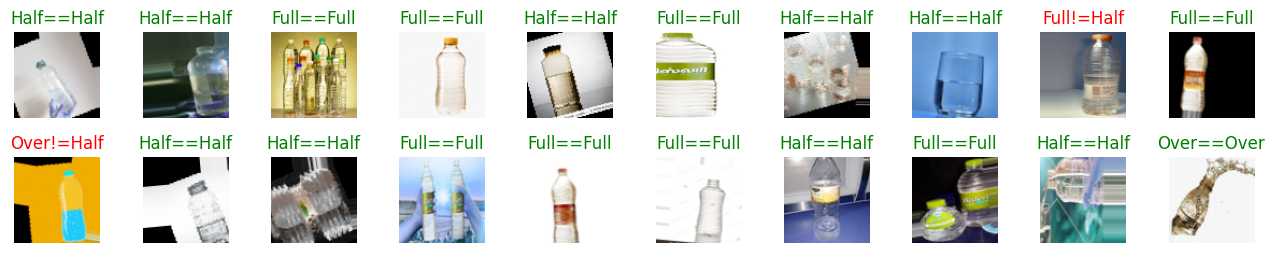

In [28]:
labels = np.array(["Full","Half","Over"])
label_dict={i: labels[i] for i in range(len(labels))}
plt.figure(figsize=(16,16))
size=20
for i in range(size):
    index = random.randint(0, x_test.shape[0])
    image = x_test[index]
    plt.subplot(10, 10, i+1)
    plt.imshow(image,  cmap=cm.gray_r)
    plt.subplots_adjust(hspace = 0.2 , wspace = 0.5)
    plt.axis('off')
    y_pred=model.predict(x_test[index:index+1], batch_size=1)
    k = np.argmax(y_pred)
    l = np.argmax(y_test[index])
    if k == l:
        plt.title(label_dict[k] + "==" + label_dict[l], color='green')
    else:
        plt.title(label_dict[k] + "!=" + label_dict[l], color='#ff0000')

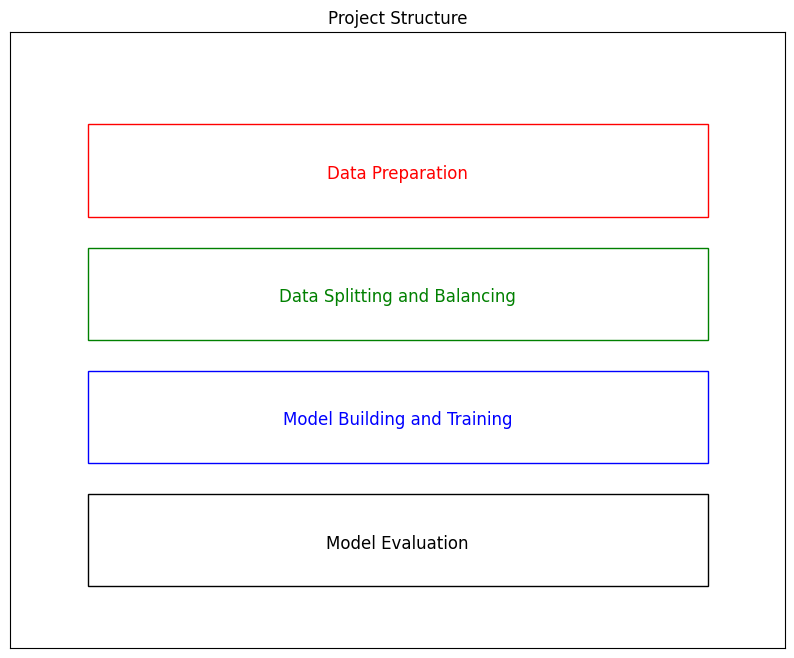

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Create a Rectangle patch for each phase
rect_data_prep = patches.Rectangle((0.1, 0.7), 0.8, 0.15, linewidth=1, edgecolor='r', facecolor='none')
rect_data_split = patches.Rectangle((0.1, 0.5), 0.8, 0.15, linewidth=1, edgecolor='g', facecolor='none')
rect_model_build = patches.Rectangle((0.1, 0.3), 0.8, 0.15, linewidth=1, edgecolor='b', facecolor='none')
rect_model_eval = patches.Rectangle((0.1, 0.1), 0.8, 0.15, linewidth=1, edgecolor='k', facecolor='none')

# Add the patches to the Axes
ax.add_patch(rect_data_prep)
ax.add_patch(rect_data_split)
ax.add_patch(rect_model_build)
ax.add_patch(rect_model_eval)

# Adding text inside each rectangle
ax.text(0.5, 0.77, 'Data Preparation', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
ax.text(0.5, 0.57, 'Data Splitting and Balancing', horizontalalignment='center', verticalalignment='center', fontsize=12, color='green')
ax.text(0.5, 0.37, 'Model Building and Training', horizontalalignment='center', verticalalignment='center', fontsize=12, color='blue')
ax.text(0.5, 0.17, 'Model Evaluation', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')

# Set axes limits and labels
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Project Structure')

plt.show()
